## Agent 1: Context-Builder

Agent responsible for extract HTML structure of web page in Selinium friendly format.

#### Prerequisites

- Download the appropriate [Chrome WebDriver](https://googlechromelabs.github.io/chrome-for-testing/)
- Set the WebDriver path in environment variable

In [35]:
from typing import TypedDict, List 
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from typing import List
from bs4 import BeautifulSoup
from typing import TypedDict, List, Optional
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from dotenv import load_dotenv
import os
from openai import OpenAI
import faiss
import numpy as np
import json

In [36]:
# Load environment variables from .env import load_env & set up OpenAI client
load_dotenv()
model = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [ ]:
# Define structure for HTML element's attributes
class HTMLElementAttribute(TypedDict):
    attribute_name: str
    attribute_value: Optional[str]

# Define structure for HTML elements
class HTMLElement(TypedDict):
    html_element_id: int
    html_element_type: str
    html_attribute : List[HTMLElementAttribute]

# Agent state and types
class AgentState(TypedDict):
    url:str
    driver: webdriver.Chrome
    html_elements: List[HTMLElement]

In [ ]:
def extract_html_structure(state: AgentState) -> AgentState:
    """Fetch the HTML from the given URL and extract HTML elements."""

    url = state["url"]
    
    try:
        driver = state["driver"]
        driver.get(url)
        
        # Wait for the page to load completely
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.TAG_NAME, "body"))
        )
        
        page_source = driver.page_source
    except Exception as e:
        print(f"Error fetching URL: {e}")
        state["html_elements"] = []
        return state

    soup = BeautifulSoup(page_source, "html.parser")

    elements: List[HTMLElement] = []

    # Define the tags and their corresponding types
    tag_type_map = [ ("input"), ("textarea"), ("button")] # ("select"), ("option"), ("a"), ("img"), ("div"), ("span") ]

    for tag_name in tag_type_map:
        for tag in soup.find_all(tag_name):
            attributes = []
            for attr_name, attr_value in tag.attrs.items():
                if isinstance(attr_value, list):
                    attr_value_str = " ".join(attr_value)
                else:
                    attr_value_str = str(attr_value)
                attributes.append({
                    "attribute_name": attr_name,
                    "attribute_value": attr_value_str
                })
            
            element: HTMLElement = {
                "html_element_id": len(elements) + 1,
                "html_element_type": tag.name,
                "html_attribute": attributes
            }
            elements.append(element)

    state["html_elements"] = elements
    return state

In [ ]:
# Step 1: Serialize HTML elements
def serialize_html_element(element):
    element_type = element['html_element_type']
    attributes = element['html_attribute']
    attrs_str = " ".join(
        f'{attr["attribute_name"]}="{(" ".join(attr["attribute_value"]) if isinstance(attr["attribute_value"], list) else attr["attribute_value"])}"'
        for attr in attributes
    )
    return f"<{element_type} {attrs_str}>"

# Step 2: Embed using OpenAI
def embed_text(text):
    response = model.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return np.array(response.data[0].embedding, dtype='float32')

def store_html_structure(state: AgentState) -> AgentState:
    """Store the HTML structure in a vector database."""

    dimension = 1536
    index = faiss.IndexFlatL2(dimension)
    id_map = {}

    for i, element in enumerate(state["html_elements"]):
        html_id = element['html_element_id']
        serialized = serialize_html_element(element)
        embedding = embed_text(serialized)
        index.add(np.array([embedding]))
        id_map[i] = html_id

    if not os.path.exists("storage"):
        os.makedirs("storage")
    
    faiss.write_index(index, os.path.join("storage", "html_index.faiss"))

    with open(os.path.join("storage", "id_map.json"), "w") as f:
        json.dump(id_map, f)
        
    with open(os.path.join("storage", "element_map.json"), "w", encoding="utf-8") as f:
        json.dump(state["html_elements"], f, ensure_ascii=False, indent=2)
    
    return state

In [40]:
graph = StateGraph(AgentState)

graph.add_node("extract_html_structure", extract_html_structure)
graph.add_node("store_html_structure", store_html_structure)

graph.add_edge("extract_html_structure", "store_html_structure")

graph.set_entry_point("extract_html_structure")
graph.set_finish_point("store_html_structure")

app = graph.compile()

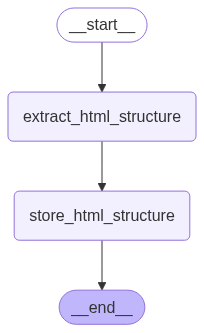

In [41]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def run_agent1(driver, url : str):
    result = app.invoke(
        AgentState(
            url = url,
            driver = driver,
            html_elements=[]
        )
    )
    return result